In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils import check_array
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import Dense,LSTM,Dropout,Activation
import os
from sklearn.metrics import mean_absolute_percentage_error

In [111]:
df=pd.read_csv('Anext_Delta_Asia.csv',usecols=['cases'])

df.head()

cases
0  177307
1  174176
2  168474
3  151498
4  152625

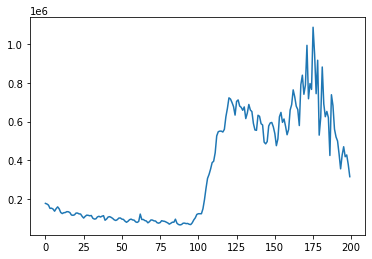

In [112]:
plt.plot(df)

In [113]:
df1=pd.read_csv('next_Delta_Asia.csv',usecols=['cases'])
window=7
rolling = df1.rolling(window)
df1 = rolling.mean()
for i in range(window-1):
    df1.iloc[i]=df.iloc[i]
df = df1

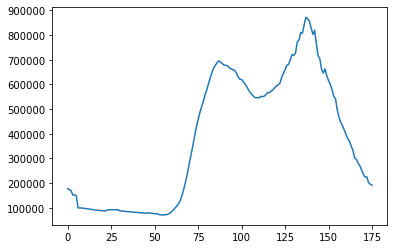

In [114]:
plt.plot(df)

In [115]:
df=df.dropna(how='all')

In [116]:
train_df,test_df =df[1:int(0.60 * len(df))],df[int(0.60 * len(df)):] 

In [117]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_252/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_252/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [118]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [222]:
n_past = 5
n_future =7
n_features = 1

In [223]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [224]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [242]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_100 (LSTM)                [(None, 5, 100),     40800       ['input_26[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_101 (LSTM)                [(None, 100),        80400       ['lstm_100[0][0]']               
                                 (None, 100),                                              

In [243]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split=0.2,batch_size=16,verbose=0)

In [155]:
#model=load_model("LSTM_3dayscases.h5")
#model=model.save("LSTM_3dayscases.h5")

In [221]:
#model=load_model("LSTM_5dayscases.h5")
#model=model.save("LSTM_5dayscases.h5")

In [250]:
model=load_model("LSTM_7dayscases.h5")
#model=model.save("LSTM_7dayscases.h5")

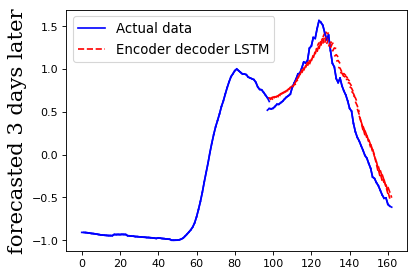

In [156]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),y_test[i],"blue")
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    
for i in range(len(y_train)):
    plt.plot(range(i,i+n_future),y_train[i],"blue")

In [157]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

cases
Day  1 :
MAE-E2D2 :  0.17027102354020085
Day  2 :
MAE-E2D2 :  0.16924171399282817
Day  3 :
MAE-E2D2 :  0.16755394276657454


mean 0.16902222676653453


In [158]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



cases
Day  1 :
MAE-E2D2 :  0.19457487841773263
Day  2 :
MAE-E2D2 :  0.19607262060270142
Day  3 :
MAE-E2D2 :  0.1968811227216152


mean 0.19584287391401642


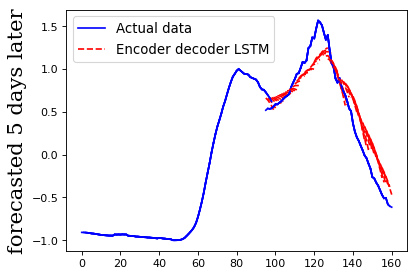

In [215]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),y_test[i],"blue")
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),pred5LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    
for i in range(len(y_train)):
    plt.plot(range(i,i+n_future),y_train[i],"blue")

In [216]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

cases
Day  1 :
MAE-E2D2 :  0.19723902548295907
Day  2 :
MAE-E2D2 :  0.19202886871245634
Day  3 :
MAE-E2D2 :  0.18587686020101182
Day  4 :
MAE-E2D2 :  0.18078548092505173
Day  5 :
MAE-E2D2 :  0.18347918000045002


mean 0.1878818830643858


In [217]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



cases
Day  1 :
MAE-E2D2 :  0.23255892283856427
Day  2 :
MAE-E2D2 :  0.2262157470184079
Day  3 :
MAE-E2D2 :  0.22234060241140707
Day  4 :
MAE-E2D2 :  0.21957376551020852
Day  5 :
MAE-E2D2 :  0.21980854367142807


mean 0.2240995162900032


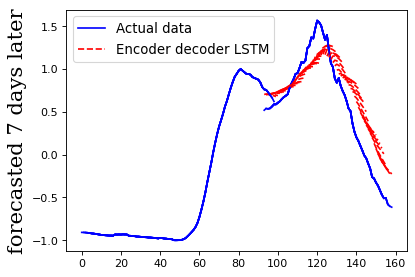

In [244]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),y_test[i],"blue")
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    
for i in range(len(y_train)):
    plt.plot(range(i,i+n_future),y_train[i],"blue")

In [245]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

cases
Day  1 :
MAE-E2D2 :  0.2229845413262306
Day  2 :
MAE-E2D2 :  0.23130280716834456
Day  3 :
MAE-E2D2 :  0.2456250801770746
Day  4 :
MAE-E2D2 :  0.26274105026245614
Day  5 :
MAE-E2D2 :  0.2823636564518662
Day  6 :
MAE-E2D2 :  0.3028246460321284
Day  7 :
MAE-E2D2 :  0.3222127962089261


mean 0.26715065394671805


In [246]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



cases
Day  1 :
MAE-E2D2 :  0.2614616973826896
Day  2 :
MAE-E2D2 :  0.27026624644296293
Day  3 :
MAE-E2D2 :  0.2869276725410866
Day  4 :
MAE-E2D2 :  0.3059577239065079
Day  5 :
MAE-E2D2 :  0.32746380934895336
Day  6 :
MAE-E2D2 :  0.34946731171858997
Day  7 :
MAE-E2D2 :  0.37071212124873537


mean 0.31032236894136084


In [ ]:
###########Delta deaths

In [256]:
df=pd.read_csv('next_Delta_Asia.csv',usecols=['deaths'])

df.head()

deaths
0    2550
1    2800
2    1526
3    1889
4    1910

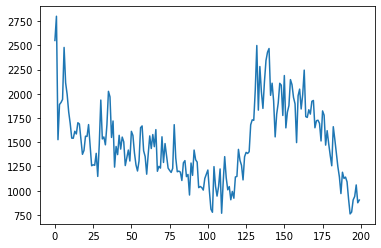

In [257]:
plt.plot(df)

In [259]:
df1=pd.read_csv('next_Delta_Asia.csv',usecols=['deaths'])
window=7
rolling = df1.rolling(window)
df1 = rolling.mean()
for i in range(window-1):
    df1.iloc[i]=df.iloc[i]
df = df1

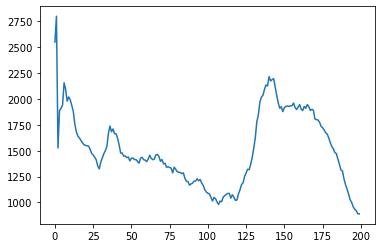

In [260]:
plt.plot(df)

In [261]:
train_df,test_df =df[1:int(0.60 * len(df))],df[int(0.60 * len(df)):] 

In [262]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_252/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_252/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [263]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [354]:
n_past = 5
n_future =7
n_features = 1

In [355]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [356]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [365]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_160 (LSTM)                [(None, 5, 100),     40800       ['input_41[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_161 (LSTM)                [(None, 100),        80400       ['lstm_160[0][0]']               
                                 (None, 100),                                              

In [366]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split=0.2,batch_size=16,verbose=0)

In [299]:
#model=load_model("LSTM_3daysdeaths.h5")
#model=model.save("LSTM_3daysdeaths.h5")

In [337]:
#model=load_model("LSTM_5daysdeaths.h5")
model=model.save("LSTM_5daysdeaths.h5")

In [370]:
model=load_model("LSTM_7daysdeaths.h5")
#model=model.save("LSTM_7daysdeaths.h5")

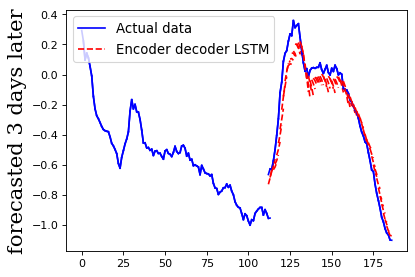

In [300]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),y_test[i],"blue")
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    
for i in range(len(y_train)):
    plt.plot(range(i,i+n_future),y_train[i],"blue")

In [301]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

deaths
Day  1 :
MAE-E2D2 :  0.07082429494009246
Day  2 :
MAE-E2D2 :  0.08545014049468513
Day  3 :
MAE-E2D2 :  0.10716457371499116


mean 0.08781300304992291


In [302]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



deaths
Day  1 :
MAE-E2D2 :  0.08906355502064468
Day  2 :
MAE-E2D2 :  0.1064666144940604
Day  3 :
MAE-E2D2 :  0.13055592300002983


mean 0.10869536417157831


In [ ]:
####5days

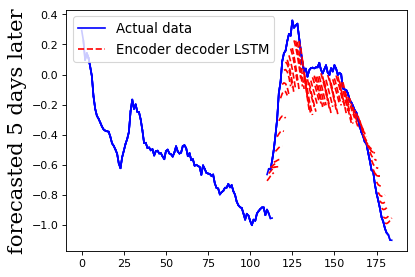

In [331]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),y_test[i],"blue")
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),pred5LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    
for i in range(len(y_train)):
    plt.plot(range(i,i+n_future),y_train[i],"blue")

In [332]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

deaths
Day  1 :
MAE-E2D2 :  0.05711928056083112
Day  2 :
MAE-E2D2 :  0.0936007048119893
Day  3 :
MAE-E2D2 :  0.13411202562622568
Day  4 :
MAE-E2D2 :  0.17836055314262167
Day  5 :
MAE-E2D2 :  0.22500420198272517


mean 0.13763935322487858


In [333]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


deaths
Day  1 :
MAE-E2D2 :  0.07119341516995693
Day  2 :
MAE-E2D2 :  0.11361500724055337
Day  3 :
MAE-E2D2 :  0.15922744225615498
Day  4 :
MAE-E2D2 :  0.20839831857924407
Day  5 :
MAE-E2D2 :  0.2592316345371532


mean 0.16233316355661254


In [ ]:
######7days

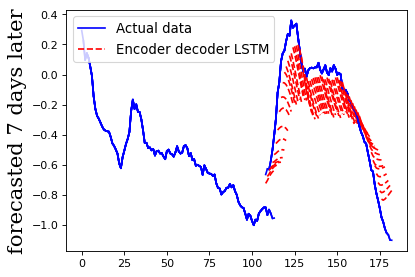

In [371]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),y_test[i],"blue")
    plt.plot(range(i+len(y_train),i+len(y_train)+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    
for i in range(len(y_train)):
    plt.plot(range(i,i+n_future),y_train[i],"blue")

In [372]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

deaths
Day  1 :
MAE-E2D2 :  0.08058162564961543
Day  2 :
MAE-E2D2 :  0.1135791568861467
Day  3 :
MAE-E2D2 :  0.15117425336203763
Day  4 :
MAE-E2D2 :  0.1904819543496773
Day  5 :
MAE-E2D2 :  0.2288368413727935
Day  6 :
MAE-E2D2 :  0.26533894386737744
Day  7 :
MAE-E2D2 :  0.2992718587553426


mean 0.18989494774899865


In [373]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


deaths
Day  1 :
MAE-E2D2 :  0.09962013944405743
Day  2 :
MAE-E2D2 :  0.14002850121261146
Day  3 :
MAE-E2D2 :  0.18274805157662602
Day  4 :
MAE-E2D2 :  0.22590773593054372
Day  5 :
MAE-E2D2 :  0.267288256927066
Day  6 :
MAE-E2D2 :  0.30675990103141487
Day  7 :
MAE-E2D2 :  0.34358997392174095


mean 0.22370608000629436
